# Hyperbolic Support Vector Classifier
`Drew Wilimitis`

In this notebook, I attempt to implement another foundational supervised learning algorithm in hyperbolic space to continue exploring how hyperbolic embeddings can be integrated with downstream machine learning tasks in order to fully exploit the representational capacity of hyperbolic geometry. <br>
<br>
I follow the approach recently outlined in "Large-margin classification in hyperbolic space". Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)

The original authors released a MATLAB implementation (https://github.com/hhcho/hyplinear) of hyperbolic support vector classifiers, which was then first implemented in python available through the excellent open-source repository - https://github.com/plumdeq/hsvm. <br>

## Algorithm Outline

Given data in the Poincare disk $\mathcal{B}^{d}$, consider supervised learning setting where we have training data instances with features $x^{j}$ and labels $y^{j}$: <br>
$$
\left\{\left(x^{(j)}, y^{(j)}\right)\right\}_{j=1}^{m}
$$ <br>
<br>
The basic steps in Hyperbolic SVM are: <br>
1. **Initialization step**: initialize weight vector $w$ that defines decision boundary <br>
2. **Optimization problem**: formulate standard euclidean max-margin optimization in hyperbolic space <br>
3. **Projected gradient descent**: iteratively solve for optimal $w$ via projected gradient descent in the hyperboloid model <br>
4. **Predict on new data samples**: use transitions between poincaré disk and hyperboloid models with decision boundary classification rules to perform supervised learning in hyperbolic space<br>

### Hyperbolic max-margin optimization  

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

## Load libraries and helper functions

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.metrics import recall_score, precision_score, auc
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
import sys
import os

# import modules within repository
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils' # path to utils folder
sys.path.append(my_path)
from utils import *
from hsvm import *
from datasets import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# Evaluating LinearHSVM

I'll attempt to evaluate this implementation of LinearHSVM on the three test cases proposed in the original publication and available online through **[1]**.

### Ex. 1) Synthetically generated gaussian mixture data

In [2]:
# read files from local path
import os
import scipy.io as sio
path = 'C:/Users/dreww/Desktop/hyplinear-master/data/gaussian'
mat_files = []
for f in os.listdir(path):
    mat_files.append(path + '/' + f)

Class 1:  [('mean_roc', 0.4950530666666667), ('mean_aucpr', 0.25712153189691417), ('mean_acc', 0.676845)]
Class 2:  [('mean_roc', 0.49826506666666665), ('mean_aucpr', 0.25771009089903735), ('mean_acc', 0.66993)]
Class 3:  [('mean_roc', 0.5054073333333333), ('mean_aucpr', 0.26124834430267685), ('mean_acc', 0.68076)]
Class 4:  [('mean_roc', 0.5003704), ('mean_aucpr', 0.2595872230354051), ('mean_acc', 0.67313)]


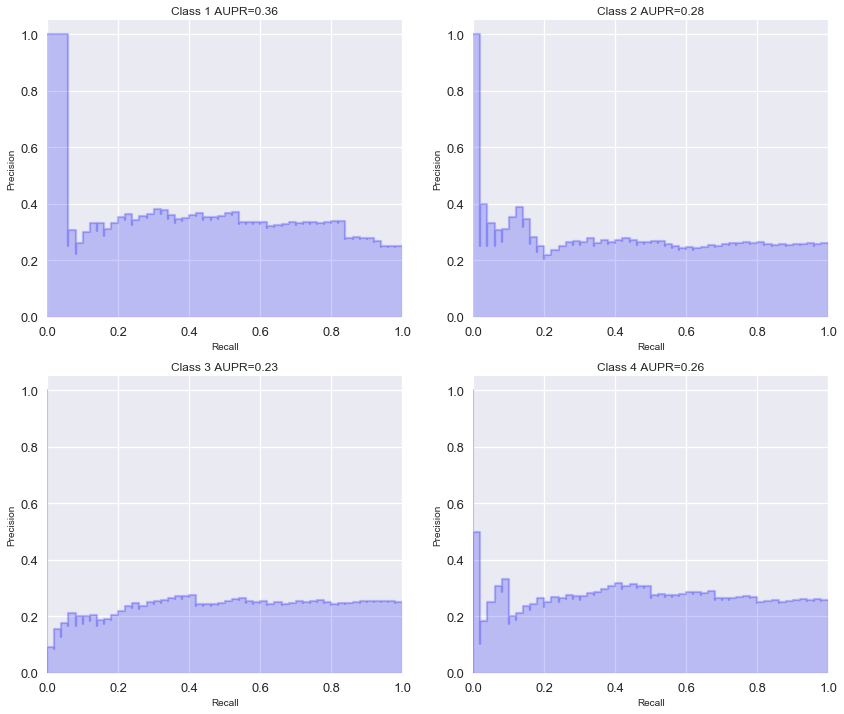

Overall macro-averaged AUPR:  0.2589167975335084
Overall macro-averaged ROC  0.4997739666666667


In [3]:
# fit each class model and display results
from inspect import signature
unique_classes = [1,2,3,4]
plt.style.use('seaborn-talk')
plt.figure(figsize=(14, 12))
macro_roc = []
macro_aupr = []
for clabel in unique_classes:
    test_results = []
    for file in mat_files:
        trial_dict = eval_ovr_gaussian(file, class_label=clabel, n_trials=5)
        test_results.append(trial_dict)
        
    final_scores = eval_metrics(test_results)
    recall_1 = final_scores['recall'][0]
    precision_1 = final_scores['precision'][0]
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    _ = plt.subplot(2, 2, clabel)
    _ = plt.step(recall_1[1], precision_1[1], color='b', alpha=0.2, where='post');
    _ = plt.fill_between(recall_1[1], precision_1[1], alpha=0.2, color='b', **step_kwargs);
    _ = plt.xlabel('Recall', size=10);
    _ = plt.ylabel('Precision', size=10);
    _ = plt.ylim([0.0, 1.05]);
    _ = plt.xlim([0.0, 1.0]);
    _ = plt.title('Class ' + str(clabel) + ' AUPR={0:0.2f}'.format(auc(recall_1[1], precision_1[1])),
                 size=12)
    print('Class ' + str(clabel) + ': ', list(final_scores.items())[:3])
    macro_roc.append(list(final_scores.items())[0][1]) 
    macro_aupr.append(list(final_scores.items())[1][1])  
plt.show();
print('Overall macro-averaged AUPR: ', np.mean(macro_aupr))
print('Overall macro-averaged ROC ', np.mean(macro_roc));

The macro averaged AUPR here might be lower than that shown in **[1]**, perhaps because I chose not to use any scaling methods to convert the hsvm decision function to formal probability measures. Additionally, the model parameters were chosen based on rough estimation instead of parameter optimization testing.

### Gaussian clusters and multiclass decision boundaries

Class 0 roc auc score:  0.221
Class 0 accuracy score:  0.75
Class 1 roc auc score:  0.038033333333333336
Class 1 accuracy score:  0.7275
Class 2 roc auc score:  0.1328666666666667
Class 2 accuracy score:  0.3275
Class 3 roc auc score:  0.5041333333333333
Class 3 accuracy score:  0.6925


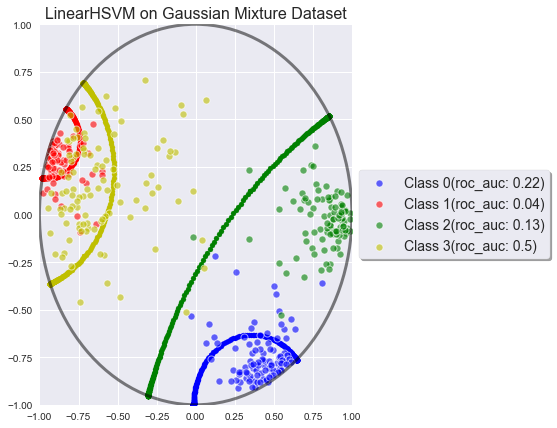

In [6]:
# visualize poincare decision boundaries for multiclass gaussian data
def plot_gaussian(X, labels):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(7,7))
    colors = ['b', 'r', 'g', 'y']
    y_binary = label_binarize(labels, classes=[1, 2, 3, 4])
    L2 = poincare_pts_to_hyperboloid(np.random.randn(1000000, 2), metric='minkowski')
    roc_scores = []
    for i in range(y_binary.shape[1]):
        hsvm_clf = LinearHSVM(early_stopping=1, C=5, num_epochs=20, lr=0.001, verbose=False)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X, metric='minkowski'), y_binary[:, i])
        w = hsvm_clf.coef_.copy()
        pred_scores = hsvm_clf.decision_function(poincare_pts_to_hyperboloid(X, metric='minkowski'))
        print('Class ' + str(i) + ' roc auc score: ', roc_auc_score(y_binary[:, i], pred_scores))
        print('Class ' + str(i) + ' accuracy score: ', hsvm_clf.score(poincare_pts_to_hyperboloid(X, metric='minkowski'), y_binary[:, i]))
        roc_scores.append(roc_auc_score(y_binary[:, i], pred_scores))
        inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-3
        dec_bound = L2[inter]
        ball_dec = hyperboloid_pts_to_poincare(dec_bound, metric='minkowski')
        ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
        if len(ball_dec) > 0:
            gamma = np.complex(1,1)
            z0 = to_complex(-1*ball_dec[np.argmin(norm(ball_dec, axis=1))])
            plot_hyp_line(10, gamma, z0, z0_label=str(i+1), color = colors[i], whole_line=True);
        #plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
    ax = plt.subplot(111)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    for i in range(y_binary.shape[1]):
        ax.scatter(X[(labels==i+1),0], X[(labels==i+1),1], c=colors[i], 
                    label='Class ' + str(i) +  '(roc_auc: ' + str(np.round(roc_scores[i], 2)) + ')',
                    alpha=0.6, edgecolors='w', linewidths=1, s=50)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, shadow=True, frameon=True)
    plt.xlim([-1.,1.])
    plt.ylim([-1.,1.])
    plt.title('LinearHSVM on Gaussian Mixture Dataset', size=16)
    plt.show();
X, y = get_gaussian_data(mat_files[90])
plot_gaussian(X, y);

## References

**[1]**. "Large-margin classification in hyperbolic space" . Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)<br>
**[2]**. https://github.com/plumdeq/hsvm <br>